<a href="https://colab.research.google.com/github/DenisPerez/NN_Tests_DG/blob/main/Experimento1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experimento 1: Estudio de todos los métodos

**Propósito:** Estudiar el desempeño y la velocidad de convergencia basado en epochs de los métodos cíclicos y el método decreciente (propio) combinados con la estrategia de Momentum


> **Nota:** Si se utilizará Google Colab como ambiente para las pruebas, se debe tomar la referencia al repositorio para que la libreta tenga acceso a los archivos que requiere


In [37]:
# !git clone https://github.com/DenisPerez/NN_Tests_DG.git
# %cd NN_Tests_DG
# %ls

Al tener disponible los archivos a referenciar, se realizan las importaciones necesarias

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from get_images import get_images
from classes import CyclicLRGiselt_Denis

# PyTorch 
import torch
import torch.nn as nn
import torch.nn.functional as F

import random

### Extracción del conjunto de datos: MNIST

Este conjundo de datos esta basado en 60.000 imágenes en el conjunto de entrenamiento y 10.000 en el conjunto de prueba de 28x28 píxeles
que representan dígitos del 0 al 9 escritos a mano y es considerado el "Hola Mundo" en el
área de la ciencia de datos. Sin embargo, **10.000  de las muestras del conjunto de entrenamiento serán destinadas al conjunto de validación** con el que se te tomará la precisión en el entrenamiento.

In [39]:
MNIST_PATH = './Dataset/'

In [40]:
x_train_num, y_train_num, x_test_num, y_test_num = get_images(MNIST_PATH)

In [41]:
# Segmento para el conjunto de entrenamiento
x_train = x_train_num[:50000].reshape(50000,-1).astype(np.float32)/255 ##Convert the traint set into a (50000, 28x28) matrix normalized
y_train = y_train_num[:50000].reshape(50000,1)

# Segmento para el conjunto de validacion
x_val = x_train_num[50000:].reshape(10000,-1).astype(np.float32)/255
y_val = y_train_num[50000:].reshape(10000,1)

# Segmento para el conjunto de prueba
x_test = x_test_num.copy().reshape(10000,-1).astype(np.float32)/255
y_test = y_test_num.copy().reshape(10000,1)

### Normalización de la muestra

In [42]:
def normalize(x_mean, x_std, x_data):
    return (x_data - x_mean) / x_std

Se toma la desviación estandar y la media de cada conjunto de datos y se llama a la función *normalize*

In [43]:
# Calculo para el conjunto de entrenamiento
x_mean = x_train.mean()
x_std = x_train.std()
x_train = normalize(x_mean, x_std, x_train)

# Calculo para el conjunto de validación
x_mean = x_val.mean()
x_std = x_val.std()
x_val = normalize(x_mean, x_std, x_val)

# Calculo para el conjunto de prueba
x_mean = x_test.mean()
x_std = x_test.std()
x_test = normalize(x_mean, x_std, x_test)

In [44]:
x_train.mean(), x_train.std()

(8.5686665e-08, 0.9999983)

### Visualización de la muestra

In [45]:
# Dimensiones del conjunto de datos de entrenamiento
x_test.shape

(10000, 784)

In [46]:
# Dimensiones del conjunto de datos de prueba:
y_train.shape

(50000, 1)

In [47]:
def plot_number(image):
    plt.figure(figsize=(5,5))
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

La imagen muestreada representa un: 6


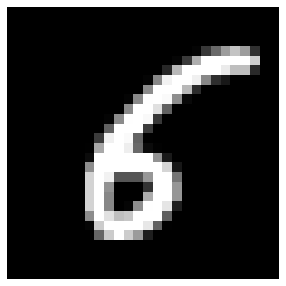

In [48]:
rnd_idx = np.random.randint(len(y_test))
print(f'La imagen muestreada representa un: {y_test[rnd_idx, 0]}')
plot_number(x_test_num[rnd_idx])

### Creación de mini lotes

In [49]:
def create_minibatches(x, y, mb_size, shuffle = True):
    '''
    x  #muestras, input_layer
    y #muestras, 1
    '''
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle: 
        idxs = np.arange(total_data, dtype=float)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]  
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

### Conversión de arreglo a tensores para todos los conjuntos de datos

In [50]:
# Conversion para el conjunto de entrenamiento
x_train_tensor = torch.Tensor(x_train.copy())
y_train_tensor = torch.Tensor(y_train.copy())

# Conversion para el conjunto de validación
x_val_tensor = torch.Tensor(x_val.copy())
y_val_tensor = torch.Tensor(y_val.copy())

# Conversion para el conjunto de prueba
x_test_tensor = torch.Tensor(x_test.copy())
y_test_tensor = torch.Tensor(y_test.copy())

### Habilitar el uso del CPU

Primero se consulta si se tiene la plataforma CUDA disponible para la utilización de los recursos de GPU

In [51]:
torch.cuda.is_available()

True

En caso de no tenerse, se asigna el trabajo de computo al CPU

In [52]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Estamos usando: {device}')

Estamos usando: cuda


# Funciones 

### Precisión

In [53]:
def accuracy(model: nn.Sequential, x: torch.tensor, y: torch.tensor, mb_size: int):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for (xi, yi) in create_minibatches(x, y, mb_size):
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size, 10
            _, pred = scores.max(dim=1) #pred shape (mb_size )
            num_correct += (pred == yi.squeeze()).sum() # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)

            return float(num_correct)/num_total  

### Entrenamiento

In [54]:
def train(model, optimizer, scheduler: None, mb_size):
    model = model.to(device=device)
    unregistered = True
    epoch_acc = 0.0
    iter_found = 0
    i = 0
    #plot lists
    acc_list = [0.0]
    cost_list = [0.0]
    lr_list = [0.0]
    while (i < 100):
        if (epoch_acc >= 0.95 and unregistered):
          iter_found = i
          unregistered = False
        for (xi, yi) in create_minibatches(x_train_tensor, y_train_tensor, mb_size):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)
            # cost function
            cost = F.cross_entropy(input= scores, target=yi.squeeze())
            optimizer.zero_grad()
            cost.backward()
            for name, param in model.named_parameters():
              ik = str(name)+'_'+str(i)
              prev_ik = str(name)+'_'+str(i-1)
            optimizer.step()
        if (scheduler != None):
          scheduler.step()
          lr = scheduler.get_last_lr()
          lr_list.append(lr[0])
        else: 
          lr = optimizer.param_groups[0]['lr']
          lr_list.append(lr)
        i+=1
        epoch_acc = accuracy(model, x_val_tensor, y_val_tensor, mb_size)
        epoch_cost = cost.item()

        #append
        acc_list.append(epoch_acc)
        cost_list.append(epoch_cost)
        print(f'Epoch: {len(acc_list) - 1}, learning_rate:{lr},costo: {epoch_cost}, accuracy: {epoch_acc}')
    return acc_list, cost_list, lr_list, iter_found

### Operaciones en las trazas

In [55]:
def SumList(first: list, second: list) -> list:
    return [x + y for x, y in zip(first[::-1], second[::-1])][::-1]

In [56]:
def DivideList(dic_list: list, number: int) -> list:
    return [x / number for x in dic_list]

In [57]:
def DeleteZerosFromList(dic_list: list) -> list:
    return list(filter(lambda num: num != 0, dic_list))

# Experiments

### Variables globales

In [58]:
MAX_ITERATIONS = 1

layer1 = 1000 
layer2 = 1000
lr = 1e-2
epochs = 100
mb_size = 4096
input_layer = 784
first_i = 0
dropout = 0.25

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
resultados = {}


## Tasa de aprendizaje fija

Mantiene un $\alpha$ constante durante todo el entrenamiento

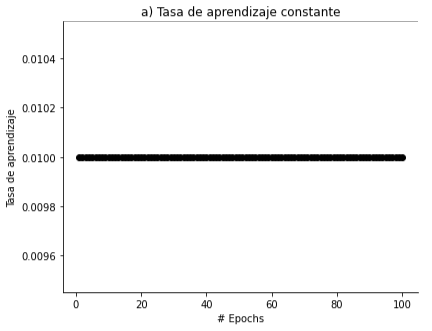

In [59]:
def Fixed():
    modelFixed = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer2, out_features=10))
    optimizer = torch.optim.SGD(modelFixed.parameters(), lr=lr)


    start.record()
    fixed_acc_list, fixed_cost_list, fixed_lr_list, fixed_epochs = train(modelFixed, optimizer,None, mb_size)
    end.record()

    torch.cuda.synchronize()
    fixed_time = start.elapsed_time(end)

    fixed_acc = accuracy(modelFixed, x_test_tensor,  y_test_tensor, mb_size)

    return fixed_acc_list, fixed_cost_list, fixed_lr_list, fixed_time, fixed_acc, fixed_epochs


In [60]:

resultados['fixed'] = {}
resultados['fixed']['val_acc_list'] = [0] * epochs
resultados['fixed']['test_acc'] = 0
resultados['fixed']['cost'] = [0] * epochs
resultados['fixed']['time'] = 0
resultados['fixed']['epochs'] = 0


for _ in range(MAX_ITERATIONS):
    fixed_acc_list, fixed_cost_list, fixed_lr_list, fixed_time, fixed_acc, fixed_epochs = Fixed()
    resultados['fixed']['val_acc_list'] = SumList(resultados['fixed']['val_acc_list'], fixed_acc_list)
    resultados['fixed']['test_acc'] += fixed_acc
    resultados['fixed']['cost'] = SumList(resultados['fixed']['cost'], fixed_cost_list)
    resultados['fixed']['time'] += fixed_time
    resultados['fixed']['epochs'] += fixed_epochs

#Saving results
resultados['fixed']['name'] = 'Fijo'
resultados['fixed']['lr'] = fixed_lr_list
resultados['fixed']['test_acc'] = resultados['fixed']['test_acc'] / MAX_ITERATIONS
resultados['fixed']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['fixed']['val_acc_list'], MAX_ITERATIONS))
resultados['fixed']['cost'] = DeleteZerosFromList(DivideList(resultados['fixed']['cost'], MAX_ITERATIONS))
resultados['fixed']['time'] = resultados['fixed']['time']/ MAX_ITERATIONS
resultados['fixed']['epochs'] = resultados['fixed']['epochs'] / MAX_ITERATIONS


Epoch: 1, learning_rate:0.01,costo: 2.2537922859191895, accuracy: 0.34765625
Epoch: 2, learning_rate:0.01,costo: 2.187642812728882, accuracy: 0.552001953125
Epoch: 3, learning_rate:0.01,costo: 2.114436626434326, accuracy: 0.673095703125
Epoch: 4, learning_rate:0.01,costo: 2.0080418586730957, accuracy: 0.702880859375
Epoch: 5, learning_rate:0.01,costo: 1.9164727926254272, accuracy: 0.727294921875
Epoch: 6, learning_rate:0.01,costo: 1.8139272928237915, accuracy: 0.747802734375
Epoch: 7, learning_rate:0.01,costo: 1.7199209928512573, accuracy: 0.748779296875
Epoch: 8, learning_rate:0.01,costo: 1.5663856267929077, accuracy: 0.77001953125
Epoch: 9, learning_rate:0.01,costo: 1.4470384120941162, accuracy: 0.790771484375
Epoch: 10, learning_rate:0.01,costo: 1.3245278596878052, accuracy: 0.794677734375
Epoch: 11, learning_rate:0.01,costo: 1.2100088596343994, accuracy: 0.80126953125
Epoch: 12, learning_rate:0.01,costo: 1.1718723773956299, accuracy: 0.82763671875
Epoch: 13, learning_rate:0.01,cost

## Tasa de aprendizaje decreciente (PyTorch)

Inicia con un $\alpha$ inicial y va decreciendo en por un factor $gamma$. El decrecimiento se da un numero $l$ de epochs definidos

$\alpha: 1x10^{-2}$

$gamma: 7x10^{-1}$

$l: 10$ epochs

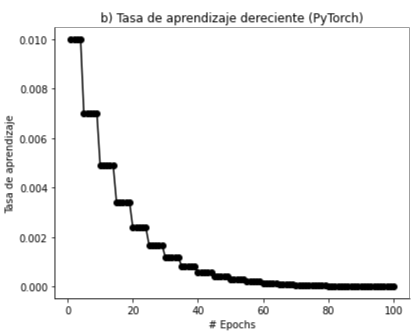

In [61]:
def Decay():
    modelDecay = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer2, out_features=10))
    optimizer = torch.optim.SGD(modelDecay.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7, last_epoch=-1, verbose=False)

    start.record()
    decay_acc_list, decay_cost_list, decay_lr_list, decay_epochs = train(modelDecay,optimizer, scheduler, mb_size)
    end.record()

    torch.cuda.synchronize()
    decay_time = start.elapsed_time(end)

    decay_acc = accuracy(modelDecay, x_test_tensor,  y_test_tensor, mb_size)
    
    return decay_acc_list, decay_cost_list, decay_lr_list, decay_time, decay_acc, decay_epochs

In [62]:

resultados['decay'] = {}
resultados['decay']['val_acc_list'] = [0] * epochs
resultados['decay']['test_acc'] = 0
resultados['decay']['cost'] = [0] * epochs
resultados['decay']['time'] = 0
resultados['decay']['epochs'] = 0


for _ in range(MAX_ITERATIONS):
    decay_acc_list, decay_cost_list, decay_lr_list, decay_time, decay_acc, decay_epochs = Decay()
    resultados['decay']['val_acc_list'] = SumList(resultados['decay']['val_acc_list'], decay_acc_list)
    resultados['decay']['test_acc'] += decay_acc
    resultados['decay']['cost'] = SumList(resultados['decay']['cost'], decay_cost_list)
    resultados['decay']['time'] += decay_time
    resultados['decay']['epochs'] += decay_epochs

#Saving results
resultados['decay']['name'] = 'Decreciente'
resultados['decay']['lr'] = decay_lr_list
resultados['decay']['test_acc'] = resultados['decay']['test_acc'] / MAX_ITERATIONS
resultados['decay']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['decay']['val_acc_list'], MAX_ITERATIONS))
resultados['decay']['cost'] = DeleteZerosFromList(DivideList(resultados['decay']['cost'], MAX_ITERATIONS))
resultados['decay']['time'] = resultados['decay']['time']/ MAX_ITERATIONS
resultados['decay']['epochs'] = resultados['decay']['epochs'] / MAX_ITERATIONS


Epoch: 1, learning_rate:[0.01],costo: 2.242668390274048, accuracy: 0.41748046875
Epoch: 2, learning_rate:[0.01],costo: 2.164562940597534, accuracy: 0.600830078125
Epoch: 3, learning_rate:[0.01],costo: 2.086693286895752, accuracy: 0.68359375
Epoch: 4, learning_rate:[0.01],costo: 2.0061140060424805, accuracy: 0.722412109375
Epoch: 5, learning_rate:[0.01],costo: 1.9018455743789673, accuracy: 0.7392578125
Epoch: 6, learning_rate:[0.01],costo: 1.7979217767715454, accuracy: 0.74658203125
Epoch: 7, learning_rate:[0.01],costo: 1.6978627443313599, accuracy: 0.764892578125
Epoch: 8, learning_rate:[0.01],costo: 1.5589544773101807, accuracy: 0.7705078125
Epoch: 9, learning_rate:[0.01],costo: 1.4478060007095337, accuracy: 0.781982421875
Epoch: 10, learning_rate:[0.006999999999999999],costo: 1.3477587699890137, accuracy: 0.80517578125
Epoch: 11, learning_rate:[0.006999999999999999],costo: 1.2213983535766602, accuracy: 0.80908203125
Epoch: 12, learning_rate:[0.006999999999999999],costo: 1.19020175933

## Tasa de aprendizaje cíclica

Oscila entre una $base\_ta$ y un $max\_ta$ cada $n$ epochs en una proporción igual a 

$$
proporción\_de\_cambio = \frac{max\_ta - base\_ta}{n}
$$

Esta implementación facilitada por PyTorch, está basada en la publicación de Tasas de aprendizaje cíclico para la red neuronal de entrenamiento (*Cyclical Learning Rates for Training Neural Networks* o por sus siglas CLR) de Leslie Smith, 2017.

$\alpha: 1x10^{-2}$

$beta: 0.9$




 

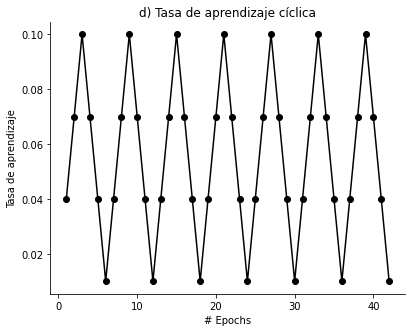

In [ ]:
def Cyclic():
    modelCyclic = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer2, out_features=10))
    optimizer = torch.optim.SGD(modelCyclic.parameters(), lr=lr)

    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1,step_size_up=3,cycle_momentum=False )

    start.record()
    cyclic_acc_list, cyclic_cost_list, cyclic_lr_list, cyclic_epochs= train(modelCyclic, optimizer,scheduler, mb_size)
    end.record()

    torch.cuda.synchronize()
    cyclic_time = start.elapsed_time(end)

    cyclic_acc = accuracy(modelCyclic, x_test_tensor,  y_test_tensor, mb_size)

    return cyclic_acc_list, cyclic_cost_list, cyclic_lr_list, cyclic_time, cyclic_acc, cyclic_epochs

In [ ]:
resultados['cyclic'] = {}
resultados['cyclic']['val_acc_list'] = [0]* epochs
resultados['cyclic']['test_acc'] = 0
resultados['cyclic']['cost'] = [0] * epochs
resultados['cyclic']['time'] = 0
resultados['cyclic']['epochs'] = 0

for _ in range(MAX_ITERATIONS):
    cyclic_acc_list, cyclic_cost_list, cyclic_lr_list, cyclic_time, cyclic_acc, cyclic_epochs = Cyclic()
    resultados['cyclic']['val_acc_list'] = SumList(resultados['cyclic']['val_acc_list'], cyclic_acc_list)
    resultados['cyclic']['test_acc'] += cyclic_acc
    resultados['cyclic']['cost'] = SumList(resultados['cyclic']['cost'], cyclic_cost_list)
    resultados['cyclic']['time'] += cyclic_time
    resultados['cyclic']['epochs'] += cyclic_epochs

#Saving results
resultados['cyclic']['name'] = 'Ciclico'
resultados['cyclic']['lr'] = cyclic_lr_list
resultados['cyclic']['test_acc'] = resultados['cyclic']['test_acc'] / MAX_ITERATIONS
resultados['cyclic']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['cyclic']['val_acc_list'], MAX_ITERATIONS))
resultados['cyclic']['cost'] = DeleteZerosFromList(DivideList(resultados['cyclic']['cost'], MAX_ITERATIONS))
resultados['cyclic']['time'] = resultados['cyclic']['time']/ MAX_ITERATIONS
resultados['cyclic']['epochs'] = resultados['cyclic']['epochs'] / MAX_ITERATIONS

Epoch: 1, learning_rate:[0.040000000000000015],costo: 2.258589029312134, accuracy: 0.324462890625
Epoch: 2, learning_rate:[0.06999999999999999],costo: 1.958723545074463, accuracy: 0.7021484375
Epoch: 3, learning_rate:[0.1],costo: 1.1988030672073364, accuracy: 0.809814453125
Epoch: 4, learning_rate:[0.07000000000000003],costo: 0.7771836519241333, accuracy: 0.74169921875
Epoch: 5, learning_rate:[0.03999999999999998],costo: 0.5462799072265625, accuracy: 0.874755859375
Epoch: 6, learning_rate:[0.01],costo: 0.5493903160095215, accuracy: 0.894287109375
Epoch: 7, learning_rate:[0.040000000000000056],costo: 0.5293974876403809, accuracy: 0.89306640625
Epoch: 8, learning_rate:[0.06999999999999995],costo: 0.49412932991981506, accuracy: 0.904052734375
Epoch: 9, learning_rate:[0.1],costo: 0.410715252161026, accuracy: 0.904296875
Epoch: 10, learning_rate:[0.06999999999999995],costo: 0.39184632897377014, accuracy: 0.90478515625
Epoch: 11, learning_rate:[0.040000000000000056],costo: 0.3430319428443908

## Tasa de aprendizaje cíclica aleatoria (propuesta)

Oscila entre una $base\_ta$ y un $max\_ta$ cada $n$ epochs en una proporción aleatoria.

$base\_ta: 1x10^{-2}$

$max\_ta: 1x10^{-1}$

$n: 3$ epochs

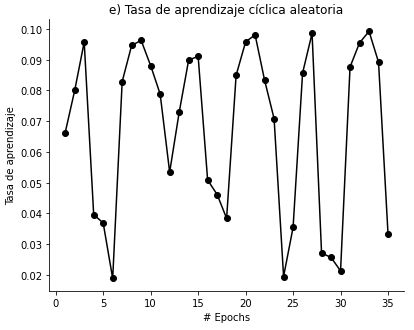

In [ ]:
def CyclicGD():
    import random
    modelRandomCyclic = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(), nn.Dropout(dropout),
                        nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(), nn.Dropout(dropout),
                        nn.Linear(in_features=layer2, out_features=10))
    optimizer = torch.optim.SGD(modelRandomCyclic.parameters(), lr=lr)

    clr_fn = lambda x, y: random.uniform(x, y)

    scheduler = CyclicLRGiselt_Denis(optimizer, base_lr=0.01, max_lr=0.1,step_size_up=3, scale_mode='chipichipi')

    start.record()
    random_cyclic_acc_list, random_cyclic_cost_list, random_cyclic_lr_list, random_cyclic_epochs= train(modelRandomCyclic, optimizer,scheduler, mb_size)
    end.record()

    torch.cuda.synchronize() 
    random_cyclic_time = start.elapsed_time(end)

    random_cyclic_acc = accuracy(modelRandomCyclic, x_test_tensor,  y_test_tensor, mb_size) 

    return random_cyclic_acc_list, random_cyclic_cost_list, random_cyclic_lr_list, random_cyclic_time, random_cyclic_acc, random_cyclic_epochs

In [ ]:
resultados['random_cyclic'] = {}
resultados['random_cyclic']['val_acc_list'] = [0] * epochs
resultados['random_cyclic']['test_acc'] = 0
resultados['random_cyclic']['cost'] = [0] * epochs
resultados['random_cyclic']['time'] = 0
resultados['random_cyclic']['epochs'] = 0

for _ in range(MAX_ITERATIONS):
    random_cyclic_acc_list, random_cyclic_cost_list, random_cyclic_lr_list, random_cyclic_time, random_cyclic_acc, random_cyclic_epochs = CyclicGD()
    a = SumList(resultados['random_cyclic']['val_acc_list'], random_cyclic_acc_list)
    resultados['random_cyclic']['val_acc_list'] = SumList(resultados['random_cyclic']['val_acc_list'], random_cyclic_acc_list)
    resultados['random_cyclic']['test_acc'] += random_cyclic_acc
    resultados['random_cyclic']['cost'] = SumList(resultados['random_cyclic']['cost'], random_cyclic_cost_list)
    resultados['random_cyclic']['time'] += random_cyclic_time
    resultados['random_cyclic']['epochs'] += random_cyclic_epochs

#Saving results
resultados['random_cyclic']['name'] = 'Random Ciclico'
resultados['random_cyclic']['lr'] = random_cyclic_lr_list
resultados['random_cyclic']['test_acc'] = resultados['random_cyclic']['test_acc'] / MAX_ITERATIONS
resultados['random_cyclic']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['random_cyclic']['val_acc_list'], MAX_ITERATIONS))
resultados['random_cyclic']['cost'] = DeleteZerosFromList(DivideList(resultados['random_cyclic']['cost'], MAX_ITERATIONS))
resultados['random_cyclic']['time'] = resultados['random_cyclic']['time']/ MAX_ITERATIONS
resultados['random_cyclic']['epochs'] = resultados['random_cyclic']['epochs'] / MAX_ITERATIONS

Epoch: 1, learning_rate:[0.09946808605654835],costo: 1.4749736785888672, accuracy: 0.76123046875
Epoch: 2, learning_rate:[0.09957696046142714],costo: 0.7661406397819519, accuracy: 0.83935546875
Epoch: 3, learning_rate:[0.09990081235866657],costo: 0.619030773639679, accuracy: 0.867919921875
Epoch: 4, learning_rate:[0.07824021622346934],costo: 0.4545654058456421, accuracy: 0.885009765625
Epoch: 5, learning_rate:[0.026255164731011763],costo: 0.4230883717536926, accuracy: 0.89892578125
Epoch: 6, learning_rate:[0.01684873490345041],costo: 0.4367106556892395, accuracy: 0.910400390625
Epoch: 7, learning_rate:[0.08175768820913018],costo: 0.4029667377471924, accuracy: 0.905029296875
Epoch: 8, learning_rate:[0.09918037417366565],costo: 0.44203847646713257, accuracy: 0.91259765625
Epoch: 9, learning_rate:[0.0995034224443629],costo: 0.3888142704963684, accuracy: 0.9140625
Epoch: 10, learning_rate:[0.04328501200830629],costo: 0.3836524188518524, accuracy: 0.916259765625
Epoch: 11, learning_rate:[0.

## Tasa de aprendizaje decreciente (Propuesta)

Inicia con una tasa de aprendizaje $\alpha$ inicial y posee una disminución de 0.001 cada $p$ epochs.

$\alpha: 1x10^{-2}$

$p: 1$ epochs

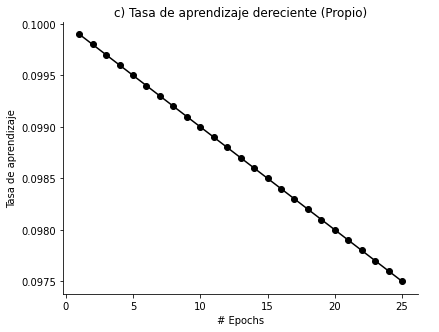

In [ ]:
def Our_Decay():
    modelOurDecay = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer2, out_features=10))
    optimizer = torch.optim.SGD(modelOurDecay.parameters(), lr=lr)


    clr_fn = lambda x, y: random.uniform(x, y)
    scheduler = CyclicLRGiselt_Denis(optimizer, base_lr=0.0001, max_lr=0.1, step_size_up=1,scale_mode='decrecimiento')

    start.record()
    our_decay_acc_list, our_decay_cost_list, our_decay_lr_list, our_decay_epochs = train(modelOurDecay,optimizer, scheduler, mb_size)
    end.record()

    torch.cuda.synchronize()
    our_decay_time = start.elapsed_time(end)

    our_decay_acc = accuracy(modelOurDecay, x_test_tensor,  y_test_tensor, mb_size)

    return our_decay_acc_list, our_decay_cost_list, our_decay_lr_list, our_decay_time, our_decay_acc, our_decay_epochs

In [ ]:
resultados['our_decay'] = {}
resultados['our_decay']['val_acc_list'] = [0] * epochs
resultados['our_decay']['test_acc'] = 0
resultados['our_decay']['cost'] = [0] * epochs
resultados['our_decay']['time'] = 0
resultados['our_decay']['epochs'] = 0

for _ in range(MAX_ITERATIONS):
    our_decay_acc_list, our_decay_cost_list, our_decay_lr_list, our_decay_time, our_decay_acc, our_decay_epochs = Our_Decay()
    resultados['our_decay']['val_acc_list'] = SumList(resultados['our_decay']['val_acc_list'], our_decay_acc_list)
    resultados['our_decay']['test_acc'] += our_decay_acc
    resultados['our_decay']['cost'] = SumList(resultados['our_decay']['cost'], our_decay_cost_list)
    resultados['our_decay']['time'] += our_decay_time
    resultados['our_decay']['epochs'] += our_decay_epochs

#Saving results
resultados['our_decay']['name'] = 'Our Decay'
resultados['our_decay']['lr'] = our_decay_lr_list
resultados['our_decay']['test_acc'] = resultados['our_decay']['test_acc'] / MAX_ITERATIONS
resultados['our_decay']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['our_decay']['val_acc_list'], MAX_ITERATIONS))
resultados['our_decay']['cost'] = DeleteZerosFromList(DivideList(resultados['our_decay']['cost'], MAX_ITERATIONS))
resultados['our_decay']['time'] = resultados['our_decay']['time'] / MAX_ITERATIONS
resultados['our_decay']['epochs'] = resultados['our_decay']['epochs'] / MAX_ITERATIONS

Epoch: 1, learning_rate:[0.0999],costo: 1.4881483316421509, accuracy: 0.747314453125
Epoch: 2, learning_rate:[0.0998],costo: 0.7426342964172363, accuracy: 0.845458984375
Epoch: 3, learning_rate:[0.0997],costo: 0.5725229382514954, accuracy: 0.861328125
Epoch: 4, learning_rate:[0.0996],costo: 0.46741941571235657, accuracy: 0.89208984375
Epoch: 5, learning_rate:[0.09949999999999999],costo: 0.4495634138584137, accuracy: 0.8955078125
Epoch: 6, learning_rate:[0.09939999999999999],costo: 0.3331425189971924, accuracy: 0.902587890625
Epoch: 7, learning_rate:[0.09929999999999999],costo: 0.36155545711517334, accuracy: 0.912109375
Epoch: 8, learning_rate:[0.09919999999999998],costo: 0.3201505243778229, accuracy: 0.92333984375
Epoch: 9, learning_rate:[0.09909999999999998],costo: 0.3155360221862793, accuracy: 0.921875
Epoch: 10, learning_rate:[0.09899999999999998],costo: 0.3364221751689911, accuracy: 0.92138671875
Epoch: 11, learning_rate:[0.09889999999999997],costo: 0.3282644748687744, accuracy: 0.

## L-BFGS

Derivado del método BFGS pero con memoria limitada. Considera información de las $h$ iteraciones previas

$\alpha: 1$

$h: 10$ iteraciones

In [ ]:
def LBFGS():
    modelLBFGS = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer2, out_features=10))

    optimizer = torch.optim.LBFGS(modelLBFGS.parameters(),
                                lr=1,
                                history_size=10, #update history size. What's this?
                                max_iter=1, #maximal number of iterations per optimization step
                                )

    lbfgs_cost_list = [0.0]
    lbfgs_acc_list = [0.0]
    modelLBFGS = modelLBFGS.to(device=device)
    x_train_tensor_ = x_train_tensor.to(device=device, dtype=torch.float32)
    y_train_tensor_ = y_train_tensor.to(device=device, dtype=torch.long)
    i = 0
    unregistered = True
    iter_found = 0
    iteraciones_lbfgs = 0
    start.record()
    #training
    while (i < 100):
        if(lbfgs_acc_list[-1] >= 0.95 and unregistered):
          iter_found = i
          unregistered = False
        #print('Iteracion: '+ str(i))
        def closure():
            optimizer.zero_grad()
            scores = modelLBFGS(x_train_tensor_)
            cost = F.cross_entropy(input= scores, target=y_train_tensor_.squeeze())
            cost.backward()
            print(f'costo: {cost.item()}')
            return cost
        iteraciones_lbfgs += 1
        cost = optimizer.step(closure)
        lbfgs_cost_list.append(cost.item())
        lbfgs_acc_list.append(accuracy(modelLBFGS, x_val_tensor, y_val_tensor, mb_size))
        #print(f'accuracy: {lbfgs_acc_list[-1]}')
        i+=1
    end.record()

    torch.cuda.synchronize()
    lbfgs_time = start.elapsed_time(end)

    lbfgs_acc = accuracy(modelLBFGS, x_test_tensor,  y_test_tensor, mb_size)

    return lbfgs_acc_list, lbfgs_cost_list, [0] ,lbfgs_time, lbfgs_acc, iter_found, iteraciones_lbfgs

In [ ]:
resultados['lbfgs'] = {}
resultados['lbfgs']['val_acc_list'] = [0] * epochs
resultados['lbfgs']['test_acc'] = 0
resultados['lbfgs']['cost'] = [0] * epochs
resultados['lbfgs']['time'] = 0
resultados['lbfgs']['epochs'] = 0

for _ in range(MAX_ITERATIONS):
    lbfgs_acc_list, lbfgs_cost_list, lbfgs_lr_list, lbfgs_time, lbfgs_acc, lbfgs_epochs, iteraciones_lbfgs = LBFGS()
    resultados['lbfgs']['val_acc_list'] = SumList(resultados['lbfgs']['val_acc_list'], lbfgs_acc_list)
    resultados['lbfgs']['test_acc'] += lbfgs_acc
    resultados['lbfgs']['cost'] = SumList(resultados['lbfgs']['cost'], lbfgs_cost_list)
    resultados['lbfgs']['time'] += lbfgs_time
    resultados['lbfgs']['epochs'] += lbfgs_epochs

#Saving results
resultados['lbfgs']['name'] = 'LBFGS'
resultados['lbfgs']['lr'] = lbfgs_lr_list
resultados['lbfgs']['test_acc'] = resultados['lbfgs']['test_acc'] / MAX_ITERATIONS
resultados['lbfgs']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['lbfgs']['val_acc_list'], MAX_ITERATIONS))
resultados['lbfgs']['cost'] = DeleteZerosFromList(DivideList(resultados['lbfgs']['cost'], MAX_ITERATIONS))
resultados['lbfgs']['time'] = resultados['lbfgs']['time'] / MAX_ITERATIONS
resultados['lbfgs']['epochs'] = resultados['lbfgs']['epochs'] / MAX_ITERATIONS



costo: 2.3018925189971924
costo: 2.296877861022949
costo: 1.8423062562942505
costo: 1.057565450668335
costo: 2.0982401371002197
costo: 0.7191731929779053
costo: 0.6339086294174194
costo: 0.5643176436424255
costo: 0.5390656590461731
costo: 0.51341712474823
costo: 0.46847742795944214
costo: 0.4527989327907562
costo: 0.41546356678009033
costo: 0.40191835165023804
costo: 0.38611912727355957
costo: 0.3579208552837372
costo: 0.3302723467350006
costo: 0.3167724311351776
costo: 0.3068915009498596
costo: 0.29940590262413025
costo: 0.2793382406234741
costo: 0.26221370697021484
costo: 0.25035908818244934
costo: 0.24259421229362488
costo: 0.23690806329250336
costo: 0.2277090698480606
costo: 0.21448685228824615
costo: 0.23279602825641632
costo: 0.19742803275585175
costo: 0.1937047392129898
costo: 0.1845531016588211
costo: 0.1781420260667801
costo: 0.17078900337219238
costo: 0.15988270938396454
costo: 0.15239885449409485
costo: 0.14993916451931
costo: 0.13616174459457397
costo: 0.13223908841609955
c

## L-BFGS con búsqueda lineal

Posee la misma implementación del método L-BFGS con la diferencia de que se agregan *las condiciones fuertes de Wolfe*

In [ ]:
def LBFGS_LS():
    modelLBFGS_LS = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer2, out_features=10))

    optimizer = torch.optim.LBFGS(modelLBFGS_LS.parameters(),
                                lr=1,
                                history_size=10, #update history size. What's this?
                                #max_eval (int) – maximal number of function evaluations per optimization step (default: max_iter * 1.25)
                                #max_iter=1,
                                line_search_fn="strong_wolfe"
                                )

    lbfgs_ls_cost_list = [0.0]
    lbfgs_ls_acc_list = [0.0]
    modelLBFGS_LS = modelLBFGS_LS.to(device=device)
    x_train_tensor_ = x_train_tensor.to(device=device, dtype=torch.float32)
    y_train_tensor_ = y_train_tensor.to(device=device, dtype=torch.long)
    i = 0
    iter_found = 0
    unregistered = True
    iteraciones_lbfgs_ls = []
    start.record()
    #training
    while (i < 100):
        if(lbfgs_acc_list[-1] >= 0.95 and unregistered):
            iter_found = i
            unregistered = False
        print('Iteracion: '+ str(i))
        def closure():
            optimizer.zero_grad()
            scores = modelLBFGS_LS(x_train_tensor_)
            cost = F.cross_entropy(input= scores, target=y_train_tensor_.squeeze())
            cost.backward()
            print(f'costo: {cost.item()}')  
            iteraciones_lbfgs_ls.append('0')
            return cost
        lbfgs_ls_cost_list.append(optimizer.step(closure).item())
        lbfgs_ls_acc_list.append(accuracy(modelLBFGS_LS, x_val_tensor, y_val_tensor, mb_size))
        i+=1
            
    #print(f'accuracy: {lbfgs_ls_acc_list[-1]}')
    end.record()

    torch.cuda.synchronize()
    lbfgs_ls_time = start.elapsed_time(end)

    lbfgs_ls_acc = accuracy(modelLBFGS_LS, x_test_tensor,  y_test_tensor, mb_size)

    return lbfgs_ls_acc_list, lbfgs_ls_cost_list, [0] ,lbfgs_ls_time, lbfgs_ls_acc, i, iteraciones_lbfgs_ls

In [ ]:
resultados['lbfgs_ls'] = {}
resultados['lbfgs_ls']['val_acc_list'] = [0] * epochs
resultados['lbfgs_ls']['test_acc'] = 0
resultados['lbfgs_ls']['cost'] = [0] * epochs
resultados['lbfgs_ls']['time'] = 0
resultados['lbfgs_ls']['epochs'] = 0

for _ in range(MAX_ITERATIONS):
    lbfgs_ls_acc_list, lbfgs_ls_cost_list, lbfgs_ls_lr_list ,lbfgs_ls_time, lbfgs_ls_acc, lbfgs_ls_epochs, iteraciones_lbfgs_ls = LBFGS_LS()
    resultados['lbfgs_ls']['val_acc_list'] = SumList(resultados['lbfgs_ls']['val_acc_list'], lbfgs_ls_acc_list)
    resultados['lbfgs_ls']['test_acc'] += lbfgs_ls_acc
    resultados['lbfgs_ls']['cost'] = SumList(resultados['lbfgs_ls']['cost'], lbfgs_ls_cost_list)
    resultados['lbfgs_ls']['time'] += lbfgs_ls_time
    resultados['lbfgs_ls']['epochs'] += lbfgs_ls_epochs

#Saving results
resultados['lbfgs_ls']['name'] = 'LBFGS With LS'
resultados['lbfgs_ls']['lr'] = lbfgs_ls_lr_list
resultados['lbfgs_ls']['test_acc'] = resultados['lbfgs_ls']['test_acc'] / MAX_ITERATIONS
resultados['lbfgs_ls']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['lbfgs_ls']['val_acc_list'], MAX_ITERATIONS))
resultados['lbfgs_ls']['cost'] = DeleteZerosFromList(DivideList(resultados['lbfgs_ls']['cost'], MAX_ITERATIONS))
resultados['lbfgs_ls']['time'] = resultados['lbfgs_ls']['time'] / MAX_ITERATIONS
resultados['lbfgs_ls']['epochs'] = resultados['lbfgs_ls']['epochs'] / MAX_ITERATIONS

Iteracion: 0
costo: 2.295626163482666
costo: 2.294271230697632
costo: 2.294049024581909
costo: 2.287043333053589
costo: 2.24869966506958
costo: 2.0932719707489014
costo: 1.5027334690093994
costo: 0.9412021636962891
costo: 0.7804862260818481
costo: 0.7157896161079407
costo: 0.6658326387405396
costo: 0.6310836672782898
costo: 0.5961260795593262
costo: 0.5550058484077454
costo: 0.5118480324745178
costo: 0.4710032343864441
costo: 0.4398357570171356
costo: 0.4150371551513672
costo: 0.39845606684684753
costo: 0.378795325756073
costo: 0.34958359599113464
costo: 0.34627974033355713
costo: 0.3125034272670746
costo: 0.30468064546585083
costo: 0.2896117866039276
Iteracion: 1
costo: 0.2645065486431122
costo: 0.2505074739456177
costo: 0.22634229063987732
costo: 0.21562273800373077
costo: 0.20688343048095703
costo: 0.19308078289031982
costo: 0.18541064858436584
costo: 0.17378947138786316
costo: 0.16191166639328003
costo: 0.15103280544281006
costo: 0.1389375627040863
costo: 0.13040950894355774
costo:

## Adam

$\alpha: 1x10^{-2}$ 

$beta1: 0.9$

$beta2: 0.999$

In [ ]:
def Adam():
    modelAdam = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(), nn.Dropout(dropout),
                        nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(), nn.Dropout(dropout),
                        nn.Linear(in_features=layer2, out_features=10))
    optimiserAdam = torch.optim.Adam(modelAdam.parameters(), lr=lr, betas=(0.9, 0.999))
    start.record()
    adam_acc_list, adam_cost_list,adam_lr_list, adam_epochs = train(modelAdam,optimiserAdam,None, mb_size)
    end.record()


    torch.cuda.synchronize()
    adam_time = start.elapsed_time(end)

    adam_acc = accuracy(modelAdam, x_test_tensor,  y_test_tensor, mb_size)

    return adam_acc_list, adam_cost_list, adam_lr_list, adam_time, adam_acc, adam_epochs

In [ ]:

resultados['adam'] = {}
resultados['adam']['val_acc_list'] = [0] * epochs
resultados['adam']['test_acc'] = 0
resultados['adam']['cost'] = [0] * epochs
resultados['adam']['time'] = 0
resultados['adam']['epochs'] = 0

for _ in range(MAX_ITERATIONS):
    adam_acc_list, adam_cost_list, adam_lr_list, adam_time, adam_acc, adam_epochs = Adam()
    resultados['adam']['val_acc_list'] = SumList(resultados['adam']['val_acc_list'], adam_acc_list)
    resultados['adam']['test_acc'] += adam_acc
    resultados['adam']['cost'] = SumList(resultados['adam']['cost'], adam_cost_list)
    resultados['adam']['time'] += adam_time
    resultados['adam']['epochs'] += adam_epochs

#Saving results
resultados['adam']['name'] = 'Adam'
resultados['adam']['lr'] = adam_lr_list
resultados['adam']['test_acc'] = resultados['adam']['test_acc'] / MAX_ITERATIONS
resultados['adam']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['adam']['val_acc_list'], MAX_ITERATIONS))
resultados['adam']['cost'] = DeleteZerosFromList(DivideList(resultados['adam']['cost'], MAX_ITERATIONS))
resultados['adam']['time'] = resultados['adam']['time'] / MAX_ITERATIONS
resultados['adam']['epochs'] = resultados['adam']['epochs'] / MAX_ITERATIONS

Epoch: 1, learning_rate:0.01,costo: 0.7792104482650757, accuracy: 0.84912109375
Epoch: 2, learning_rate:0.01,costo: 0.3772437572479248, accuracy: 0.91943359375
Epoch: 3, learning_rate:0.01,costo: 0.27591776847839355, accuracy: 0.944091796875
Epoch: 4, learning_rate:0.01,costo: 0.2081216722726822, accuracy: 0.95166015625
Epoch: 5, learning_rate:0.01,costo: 0.22218488156795502, accuracy: 0.96142578125
Epoch: 6, learning_rate:0.01,costo: 0.19708259403705597, accuracy: 0.963134765625
Epoch: 7, learning_rate:0.01,costo: 0.16068880259990692, accuracy: 0.9658203125
Epoch: 8, learning_rate:0.01,costo: 0.18117272853851318, accuracy: 0.968017578125
Epoch: 9, learning_rate:0.01,costo: 0.17429152131080627, accuracy: 0.96484375
Epoch: 10, learning_rate:0.01,costo: 0.13499291241168976, accuracy: 0.96923828125
Epoch: 11, learning_rate:0.01,costo: 0.10433357954025269, accuracy: 0.97119140625
Epoch: 12, learning_rate:0.01,costo: 0.1467696577310562, accuracy: 0.974853515625
Epoch: 13, learning_rate:0.01

## Momentum

Se utiliza una optimización por el descenso del gradiente estocástico empleando Momentum.

$beta: 0.9$

In [ ]:
def SGDM():
    modelSGDM = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer2, out_features=10))
    optimiserSGDM = torch.optim.SGD(modelSGDM.parameters(), lr=lr, momentum=0.9)
    start.record()
    SGDM_acc_list, SGDM_cost_list,SGDM_lr_list, SGDM_epochs = train(modelSGDM, optimiserSGDM,None, mb_size)
    end.record()

    torch.cuda.synchronize()
    SGDM_time = start.elapsed_time(end)

    SGDM_acc = accuracy(modelSGDM, x_test_tensor,  y_test_tensor, mb_size)

    return SGDM_acc_list, SGDM_cost_list, SGDM_lr_list, SGDM_time, SGDM_acc, SGDM_epochs

In [ ]:
resultados['SGDM'] = {}
resultados['SGDM']['val_acc_list'] = [0] * epochs
resultados['SGDM']['test_acc'] = 0
resultados['SGDM']['cost'] = [0] * epochs
resultados['SGDM']['time'] = 0
resultados['SGDM']['epochs'] = 0

for _ in range(MAX_ITERATIONS):
    SGDM_acc_list, SGDM_cost_list, SGDM_lr_list, SGDM_time, SGDM_acc, SGDM_epochs = SGDM()
    resultados['SGDM']['val_acc_list'] = SumList(resultados['SGDM']['val_acc_list'], SGDM_acc_list)
    resultados['SGDM']['test_acc'] += SGDM_acc
    resultados['SGDM']['cost'] = SumList(resultados['SGDM']['cost'], SGDM_cost_list)
    resultados['SGDM']['time'] += SGDM_time
    resultados['SGDM']['epochs'] += SGDM_epochs

#Saving results
resultados['SGDM']['name'] = 'SGDM'
resultados['SGDM']['lr'] = SGDM_lr_list
resultados['SGDM']['test_acc'] = resultados['SGDM']['test_acc'] / MAX_ITERATIONS
resultados['SGDM']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['SGDM']['val_acc_list'], MAX_ITERATIONS))
resultados['SGDM']['cost'] = DeleteZerosFromList(DivideList(resultados['SGDM']['cost'], MAX_ITERATIONS))
resultados['SGDM']['time'] = resultados['SGDM']['time'] / MAX_ITERATIONS
resultados['SGDM']['epochs'] = resultados['SGDM']['epochs'] / MAX_ITERATIONS


Epoch: 1, learning_rate:0.01,costo: 1.9996079206466675, accuracy: 0.736328125
Epoch: 2, learning_rate:0.01,costo: 1.2691693305969238, accuracy: 0.791015625
Epoch: 3, learning_rate:0.01,costo: 0.6549959182739258, accuracy: 0.86474609375
Epoch: 4, learning_rate:0.01,costo: 0.5310620665550232, accuracy: 0.881103515625
Epoch: 5, learning_rate:0.01,costo: 0.4369184672832489, accuracy: 0.8896484375
Epoch: 6, learning_rate:0.01,costo: 0.41046735644340515, accuracy: 0.908203125
Epoch: 7, learning_rate:0.01,costo: 0.35670626163482666, accuracy: 0.912353515625
Epoch: 8, learning_rate:0.01,costo: 0.34854623675346375, accuracy: 0.914794921875
Epoch: 9, learning_rate:0.01,costo: 0.3630813658237457, accuracy: 0.919189453125
Epoch: 10, learning_rate:0.01,costo: 0.3559630811214447, accuracy: 0.921142578125
Epoch: 11, learning_rate:0.01,costo: 0.3367641866207123, accuracy: 0.918701171875
Epoch: 12, learning_rate:0.01,costo: 0.27853044867515564, accuracy: 0.9208984375
Epoch: 13, learning_rate:0.01,costo

## RMSProp

$\alpha: 1x10^{-2}$ 

$beta: 0.9$


In [ ]:
def RMSP():
    modelRMSP = nn.Sequential(nn.Linear(in_features=input_layer, out_features=layer1), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer1, out_features=layer2), nn.ReLU(), nn.Dropout(dropout),
                       nn.Linear(in_features=layer2, out_features=10))
    optimiserRMSP = torch.optim.RMSprop(modelRMSP.parameters(), lr=lr, alpha=0.9)
    start.record()
    RMSP_acc_list, RMSP_cost_list,RMSP_lr_list, RMSP_epochs = train(modelRMSP, optimiserRMSP,None, mb_size)
    end.record()

    torch.cuda.synchronize()
    RMSP_time = start.elapsed_time(end)

    RMSP_acc = accuracy(modelRMSP, x_test_tensor,  y_test_tensor, mb_size)

    return RMSP_acc_list, RMSP_cost_list, RMSP_lr_list, RMSP_time, RMSP_acc, RMSP_epochs

In [ ]:
resultados['RMSP'] = {}
resultados['RMSP']['val_acc_list'] = [0] * epochs
resultados['RMSP']['test_acc'] = 0
resultados['RMSP']['cost'] = [0] * epochs
resultados['RMSP']['time'] = 0
resultados['RMSP']['epochs'] = 0

for _ in range(MAX_ITERATIONS):
    RMSP_acc_list, RMSP_cost_list, RMSP_lr_list, RMSP_time, RMSP_acc, RMSP_epochs = SGDM()
    resultados['RMSP']['val_acc_list'] = SumList(resultados['RMSP']['val_acc_list'], RMSP_acc_list)
    resultados['RMSP']['test_acc'] += RMSP_acc
    resultados['RMSP']['cost'] = SumList(resultados['RMSP']['cost'], RMSP_cost_list)
    resultados['RMSP']['time'] += RMSP_time
    resultados['RMSP']['epochs'] += RMSP_epochs

#Saving results
resultados['RMSP']['name'] = 'RMSP'
resultados['RMSP']['lr'] = RMSP_lr_list
resultados['RMSP']['test_acc'] = resultados['RMSP']['test_acc'] / MAX_ITERATIONS
resultados['RMSP']['val_acc_list'] = DeleteZerosFromList(DivideList(resultados['RMSP']['val_acc_list'], MAX_ITERATIONS))
resultados['RMSP']['cost'] = DeleteZerosFromList(DivideList(resultados['RMSP']['cost'], MAX_ITERATIONS))
resultados['RMSP']['time'] = resultados['RMSP']['time'] / MAX_ITERATIONS
resultados['RMSP']['epochs'] = resultados['RMSP']['epochs'] / MAX_ITERATIONS

Epoch: 1, learning_rate:0.01,costo: 2.026369571685791, accuracy: 0.679443359375
Epoch: 2, learning_rate:0.01,costo: 1.2387704849243164, accuracy: 0.80078125
Epoch: 3, learning_rate:0.01,costo: 0.7061814069747925, accuracy: 0.856689453125
Epoch: 4, learning_rate:0.01,costo: 0.6021997332572937, accuracy: 0.883056640625
Epoch: 5, learning_rate:0.01,costo: 0.4473430812358856, accuracy: 0.89306640625
Epoch: 6, learning_rate:0.01,costo: 0.4129355549812317, accuracy: 0.903076171875
Epoch: 7, learning_rate:0.01,costo: 0.40654289722442627, accuracy: 0.902587890625
Epoch: 8, learning_rate:0.01,costo: 0.33667194843292236, accuracy: 0.91162109375
Epoch: 9, learning_rate:0.01,costo: 0.3574228882789612, accuracy: 0.916259765625
Epoch: 10, learning_rate:0.01,costo: 0.3805488646030426, accuracy: 0.915283203125
Epoch: 11, learning_rate:0.01,costo: 0.3101024031639099, accuracy: 0.920166015625
Epoch: 12, learning_rate:0.01,costo: 0.32550692558288574, accuracy: 0.917236328125
Epoch: 13, learning_rate:0.01

# Resultados

Al guardar todos los resultados de cada método en sus respectivos diccionarios, se procede a crear un dataframe con estos resultados. Adicionalmente, se generan nuevas columnas derivadas de datos que ya disponemos y se hacen tratamiento de formato para su análisis.

In [ ]:
for key, _ in resultados.items():
    if( resultados[key]['val_acc_list'][0] == 0 ):
        continue
    resultados[key]['val_acc_list'].insert(0,0)

In [ ]:
import pandas as pd
resultados_df = pd.DataFrame(resultados.copy()).T

resultados_df['val_acc'] = resultados_df.apply(lambda row: round(row['val_acc_list'][-1]* 100,2), axis=1)
resultados_df['test_acc'] = resultados_df.apply(lambda row: round(row['test_acc']*100,2), axis=1)
# resultados_df['epochs'] = resultados_df.apply(lambda row: len(row['val_acc_list']), axis=1)
resultados_df['time'] = resultados_df.apply(lambda row: round(row['time']/(100000),2), axis=1)
resultados_df['val_acc'] = resultados_df.apply(lambda row: '{acc}%'.format(acc = row['val_acc']), axis=1)
resultados_df['test_acc'] = resultados_df.apply(lambda row: '{acc}%'.format(acc = row['test_acc']), axis=1)

resultados_df = resultados_df.sort_values(by=['epochs'],ascending=True)

### L-BFGS vs L-BFGS con búsqueda lineal

Comparación de número de veces que se procesa el conjunto de datos de pruebas completo

In [ ]:
print(f'L-BFGS: {iteraciones_lbfgs}, L-BFGS con búsqueda:{len(iteraciones_lbfgs_ls)}')

L-BFGS: 100, L-BFGS con búsqueda:202


### Comportamiento de las trazas de aprendizaje no adaptativas

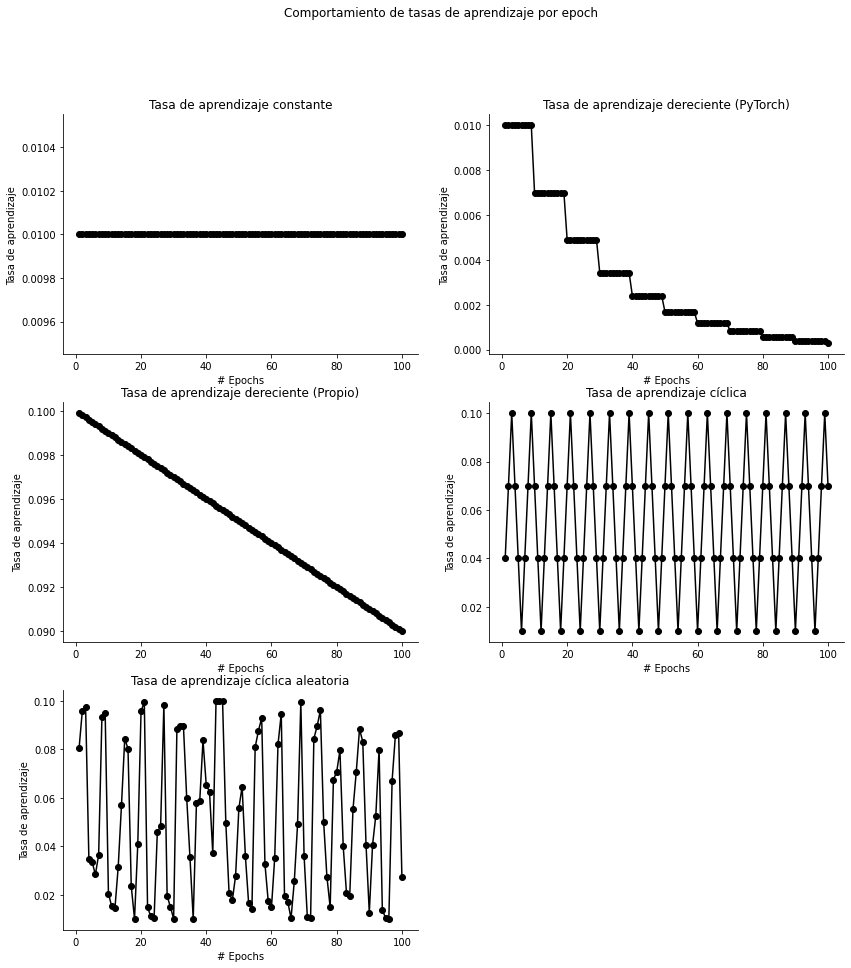

In [ ]:
from matplotlib.ticker import MultipleLocator

fig, ax = plt.subplots(3,2,figsize=(14, 15))

method = [fixed_lr_list, decay_lr_list, our_decay_lr_list,cyclic_lr_list, random_cyclic_lr_list]
names = ['Tasa de aprendizaje constante', 'Tasa de aprendizaje dereciente (PyTorch)', 'Tasa de aprendizaje dereciente (Propio)', 'Tasa de aprendizaje cíclica', 'Tasa de aprendizaje cíclica aleatoria']
i = 0
for a in range(3):
  for b in range(2):
    if(a==2 and b==1):
      ax[a,b].spines['top'].set_visible(False)
      ax[a,b].spines['right'].set_visible(False)
      ax[a,b].spines['bottom'].set_visible(False)
      ax[a,b].spines['left'].set_visible(False)
      plt.axis('off')
      break
    ax[a,b].plot(range(len(method[i]))[1:], 
            method[i][1:], 
            'black',
            marker = 'o')
    #ax[a,b].set_xlim([1, len(method[i])])
    #ax[a,b].set_ylim([0, max(method[i]) + 0.01])
    ax[a,b].set_xlabel('# Epochs') #, fontsize = 18)
    ax[a,b].set_ylabel('Tasa de aprendizaje') #, fontsize = 18)
    ax[a,b].spines['top'].set_visible(False)
    ax[a,b].spines['right'].set_visible(False)
    #ax[a,b].xaxis.set_major_locator(MultipleLocator(len(method[i])//4))
    #ax[a,b].xaxis.set_minor_locator(MultipleLocator(len(method[i])//4))
    ax[a,b].set_title(names[i])
    i+=1


fig.suptitle('Comportamiento de tasas de aprendizaje por epoch')
fig.show()

### Velocidad de convergencia basado en epochs

In [ ]:
resultados_df = resultados_df.sort_values(by=['epochs'],ascending=True)

In [ ]:
resultados_df[['name','epochs','time']].style.hide_index()

<ipython-input-57-6e8f50f7ef4d>:1: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  resultados_df[['name','epochs','time']].style.hide_index()


name,epochs,time
LBFGS With LS,100.000000,27.460000
LBFGS,32.666667,13.950000
Adam,3.800000,25.000000
Our Decay,23.466667,25.060000
SGDM,26.200000,25.180000
RMSP,25.466667,25.220000
Random Ciclico,40.266667,25.070000
Ciclico,42.733333,25.050000
Fijo,0.000000,25.540000
Decreciente,0.000000,24.950000


### Curvas de aprendizaje: precisión


In [ ]:
resultados_df = resultados_df.sort_values(by=['test_acc'],ascending=False)
resultados_df[['name','val_acc','time','test_acc']].style.hide_index()

<ipython-input-56-843c3356dcfc>:2: FutureWarning: this method is deprecated in favour of `Styler.hide(axis='index')`
  resultados_df[['name','val_acc','time','test_acc']].style.hide_index()


name,val_acc,time,test_acc
LBFGS With LS,98.23%,27.460000,98.22%
LBFGS,98.17%,13.950000,98.12%
Adam,97.73%,25.000000,97.57%
Our Decay,97.65%,25.060000,97.57%
SGDM,97.58%,25.180000,97.45%
RMSP,97.56%,25.220000,97.44%
Random Ciclico,96.98%,25.070000,96.55%
Ciclico,96.88%,25.050000,96.45%
Fijo,92.27%,25.540000,92.14%
Decreciente,89.46%,24.950000,88.55%


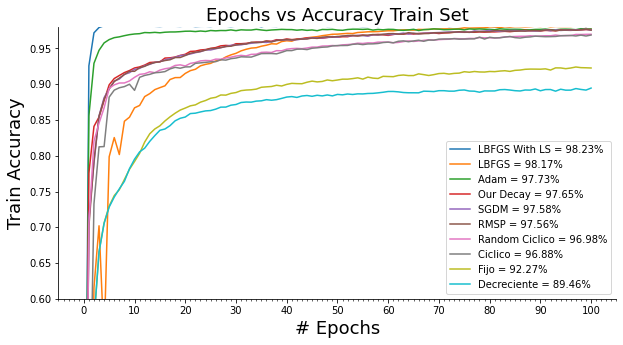

In [ ]:
from matplotlib.ticker import MultipleLocator

bbox = dict(boxstyle ="round", fc ="1")
arrowprops = dict(
    arrowstyle = "->")
offset = 72

fig, ax = plt.subplots(figsize=(10, 5))


for k1 in resultados_df.index:
    ax.plot(range(len(resultados_df.loc[k1,'val_acc_list'])),
        resultados_df.loc[k1,'val_acc_list'],
        label='{name} = {acc}%'.format(name= resultados_df.loc[k1,'name'],
                                       acc = round(resultados_df.loc[k1,'val_acc_list'][-1] * 100 , 2)))

plt.title('Epochs vs Accuracy Train Set', fontsize = 18)

#ax.set_xlim([0, 50])
ax.set_ylim([0.6, 0.98])
#plt.yscale('log')

ax.set_xlabel('# Epochs', fontsize = 18)
ax.set_ylabel('Train Accuracy', fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.legend()

# ax.annotate('data = (%.1f, %.1f)'%(14, 0.95),
#             (14, 0.95), xytext =(1 + 14,0.95),
#             textcoords ='offset points',
#             bbox = bbox, arrowprops = arrowprops)

plt.show()

### Curvas de aprendizaje: pérdida en la función de costo

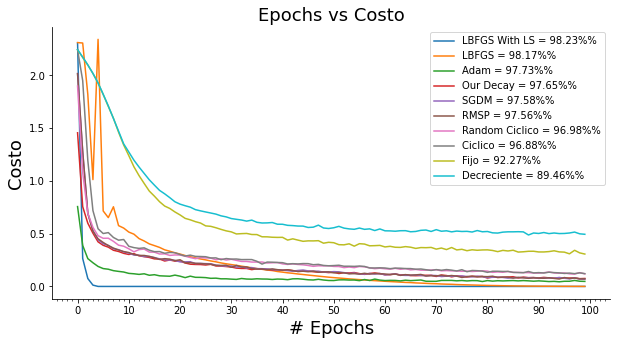

In [ ]:
from matplotlib.ticker import MultipleLocator

bbox = dict(boxstyle ="round", fc ="1")
arrowprops = dict(
    arrowstyle = "->")
offset = 72

fig, ax = plt.subplots(figsize=(10, 5))


for k1 in resultados_df.index:
    ax.plot(range(len(resultados_df.loc[k1,'cost'])),
        resultados_df.loc[k1,'cost'],
        label='{name} = {acc}%'.format(name= resultados_df.loc[k1,'name'],
                                       acc = resultados_df.loc[k1,'val_acc']))

plt.title('Epochs vs Costo', fontsize = 18)


ax.set_xlabel('# Epochs', fontsize = 18)
ax.set_ylabel('Costo', fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.legend()

# ax.annotate('data = (%.1f, %.1f)'%(14, 0.95),
#             (14, 0.95), xytext =(1 + 14,0.95),
#             textcoords ='offset points',
#             bbox = bbox, arrowprops = arrowprops)

plt.show()